# Denoising with the deep decoder

The code below demonstrates the denoising performance on an example image.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from models import * # from DIP paper repository
#from utils.denoising_utils import *


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def denoise(img_noisy_np,img_clean_np,net,num_channels,numit = 1900,rn = 0.0,find_best=True,upsample_mode='bilinear'):
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=np_to_var(img_noisy_np).type(dtype),
                        net=net,
                        img_clean_var=np_to_var(img_clean_np).type(dtype),
                        find_best=find_best,
                        upsample_mode=upsample_mode,
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t

## Load imagenet images

In [3]:
def get_imgnet_imgs(path = './imgs/'):
    siz = 512
    imgs = []
    imgnames = [f for f in listdir(path) if isfile(join(path, f))]   
    for imgname in imgnames:
        # prepare and select image
        imgname = path + imgname
        print(imgname)
        img = load_and_crop(imgname,target_width=512,target_height=512)
        if img is None: # then the image could not be croped to 512x512
            continue
        
        img_np = pil_to_np(img)

        if img_np.shape[0] != 3: # we only want to consider color images
            continue
        imgs += [img_np]
    print("got ", len(imgs), " images")
    return imgs

imgs = get_imgnet_imgs()

./imgs/ILSVRC2012_val_00019801.JPEG
./imgs/ILSVRC2012_val_00006356.JPEG
./imgs/ILSVRC2012_val_00013400.JPEG
./imgs/ILSVRC2012_val_00002766.JPEG
./imgs/ILSVRC2012_val_00018466.JPEG
./imgs/ILSVRC2012_val_00005181.JPEG
./imgs/ILSVRC2012_val_00001694.JPEG
./imgs/ILSVRC2012_val_00016033.JPEG
./imgs/ILSVRC2012_val_00010028.JPEG
./imgs/ILSVRC2012_val_00016202.JPEG
./imgs/ILSVRC2012_val_00014683.JPEG
./imgs/ILSVRC2012_val_00002957.JPEG
./imgs/ILSVRC2012_val_00004387.JPEG
./imgs/ILSVRC2012_val_00008163.JPEG
./imgs/ILSVRC2012_val_00006729.JPEG
./imgs/ILSVRC2012_val_00015629.JPEG
./imgs/ILSVRC2012_val_00012103.JPEG
./imgs/ILSVRC2012_val_00009380.JPEG
./imgs/ILSVRC2012_val_00015033.JPEG
./imgs/ILSVRC2012_val_00017156.JPEG
./imgs/ILSVRC2012_val_00016702.JPEG
./imgs/ILSVRC2012_val_00017100.JPEG
./imgs/ILSVRC2012_val_00005124.JPEG
./imgs/ILSVRC2012_val_00005636.JPEG
./imgs/ILSVRC2012_val_00010051.JPEG
./imgs/ILSVRC2012_val_00019106.JPEG
./imgs/ILSVRC2012_val_00017996.JPEG
./imgs/ILSVRC2012_val_000191

### Function for generating a noisy image

In [4]:
def get_noisy_img(img_np,sig=25.0,noise_same = True):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    #img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np #,img_noisy_var

#  Denoising

In [5]:
sig = 25.0
noise_same = True # we want to have the same noise in each color channel, to study the capability as a image prior.

## DIP

In [7]:
psnrs = []
for i,img in enumerate(imgs):
    # get noisy img
    img_noisy_np = get_noisy_img(img,sig,noise_same)
    output_depth = img.shape[0] 
  
    # denoise
    numit = 1800
    #numit = 500
    output_depth = 3
    net = get_net(32, 'skip', 'reflection',n_channels=output_depth,skip_n33d=128,
              skip_n33u=128,skip_n11=4,num_scales=5,upsample_mode='bilinear').type(dtype)
    num_channels = [32]*5
    
    rn = 1./30.
    out_img_np, mse_t = denoise(img_noisy_np,img,net,num_channels=num_channels,numit = numit,rn = rn,upsample_mode="none")
    psnrv = psnr(img,out_img_np)
    
    psnrv = psnr(img,out_img_np)
    psnrs.append(psnrv)
    print(i, np.mean(psnrs))
    
    #plt.semilogy(mse_t)
    #plt.show()
    
    #fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    #ax1 = fig.add_subplot(131)
    #myimgshow(ax1,img) 
    #ax1.set_title('Original image')
    #ax1.axis('off')
    
    #ax2 = fig.add_subplot(132)
    #myimgshow(ax2,img_noisy_np)
    #ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img,img_noisy_np) )
    #ax2.axis('off')  

    #ax3 = fig.add_subplot(133)
    #myimgshow(ax3,out_img_np)
    #ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % psnr(img,out_img_np) ) 
    #ax3.axis('off') 
    
    plt.show()
     
print(np.mean(psnrs))
print(np.mean(psnrs))

input shape:  [1, 32, 512, 512]
optimize with adam 0.01
0 24.003140197707822rain loss 0.008955  Actual loss 0.004066 Actual loss orig 0.003908 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
1 24.41631812898393Train loss 0.008513  Actual loss 0.003628 Actual loss orig 0.003183 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
2 24.404591624995188rain loss 0.008756  Actual loss 0.003857 Actual loss orig 0.003514 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
3 25.146451546237856rain loss 0.007265  Actual loss 0.001628 Actual loss orig 0.001848 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
4 25.143742764628907rain loss 0.008235  Actual loss 0.003226 Actual loss orig 0.003161 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
5 25.263504408803566rain loss 0.008376  Actual loss 0.002755 Actual loss orig 0.002595 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
6 25.20044368349218Train loss 0.007747  Actual loss 0.003207 Actual loss orig 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



51 25.709337244832078ain loss 0.008500  Actual loss 0.002989 Actual loss orig 0.002843 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
52 25.731641163152503ain loss 0.006826  Actual loss 0.001899 Actual loss orig 0.002212 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
53 25.752260548753117ain loss 0.006085  Actual loss 0.002009 Actual loss orig 0.002062 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
54 25.74054697135627rain loss 0.007629  Actual loss 0.002822 Actual loss orig 0.003183 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
55 25.738011228438204ain loss 0.007587  Actual loss 0.002286 Actual loss orig 0.002772 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
56 25.74770764863972rain loss 0.003789  Actual loss 0.002283 Actual loss orig 0.002399 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
57 25.76795684067356rain loss 0.007859  Actual loss 0.002013 Actual loss orig 0.002082 
input shape:  [1, 32, 512, 512]
optimize with ad

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



91 25.725394333824035ain loss 0.007942  Actual loss 0.002143 Actual loss orig 0.002300 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
92 25.736275757760758ain loss 0.006748  Actual loss 0.001938 Actual loss orig 0.002008 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
93 25.74435660133997rain loss 0.007994  Actual loss 0.002532 Actual loss orig 0.002289 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
94 25.736972438254107ain loss 0.007009  Actual loss 0.002769 Actual loss orig 0.003180 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
95 25.739330263165467ain loss 0.007608  Actual loss 0.002325 Actual loss orig 0.002415 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
96 25.723552239918458ain loss 0.008738  Actual loss 0.003867 Actual loss orig 0.003908 
input shape:  [1, 32, 512, 512]
optimize with adam 0.01
97 25.74299350602101rain loss 0.006263  Actual loss 0.001707 Actual loss orig 0.001783 
input shape:  [1, 32, 512, 512]
optimize with ad

## Deep Decoder

In [7]:
psnrs = []
psnrsnoisy = []
for i,img in enumerate(imgs):
    # get noisy img
    img_noisy_np = get_noisy_img(img,sig,noise_same)
    output_depth = img.shape[0] 
    
    # denoise with DD
    num_channels = [128]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=False).type(dtype)
    out_img_np, mse_t = denoise(img_noisy_np,img,net,num_channels=num_channels,numit = 3000)
    
    psnrv = psnr(img,out_img_np)
    psnrs.append(psnrv)
    
    psnrsnoisy.append( psnr(img,img_noisy_np) )
    
    print(i, np.mean(psnrs))
    
    #plt.semilogy(mse_t)
    #plt.show()
    
print(np.mean(psnrs))
print(np.mean(psnrs))
print(np.mean(psnrsnoisy))

input shape:  [1, 128, 16, 16]
optimize with adam 0.01
0 25.033915434131533rain loss 0.011045  Actual loss 0.003454 Actual loss orig 0.003454 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
1 24.715163906335118rain loss 0.010044  Actual loss 0.003563 Actual loss orig 0.003563 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
2 24.660156673321335rain loss 0.010505  Actual loss 0.003573 Actual loss orig 0.003573 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
3 26.411204898371913rain loss 0.007930  Actual loss 0.000816 Actual loss orig 0.000816 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
4 26.356631610772638rain loss 0.009415  Actual loss 0.002603 Actual loss orig 0.002603 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
5 26.357486502378354rain loss 0.009496  Actual loss 0.002437 Actual loss orig 0.002437 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
6 26.28118679392988Train loss 0.009957  Actual loss 0.003245 Actual loss orig 0.003245 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



62 27.899801484240832ain loss 0.008674  Actual loss 0.001622 Actual loss orig 0.001622 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
63 27.943683033182598ain loss 0.008467  Actual loss 0.001164 Actual loss orig 0.001164 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
64 27.901582815614137ain loss 0.009974  Actual loss 0.003465 Actual loss orig 0.003465 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
65 27.831347315858217ain loss 0.012739  Actual loss 0.005617 Actual loss orig 0.005617 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
66 27.8537247046603Train loss 0.008805  Actual loss 0.001441 Actual loss orig 0.001441 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
67 27.884640391114726ain loss 0.008609  Actual loss 0.001177 Actual loss orig 0.001177 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
68 27.89908243052407rain loss 0.008748  Actual loss 0.001345 Actual loss orig 0.001345 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



78 27.946854800612407ain loss 0.008370  Actual loss 0.001072 Actual loss orig 0.001072 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
79 27.924569903909934ain loss 0.009132  Actual loss 0.002667 Actual loss orig 0.002667 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
80 27.84036428940474rain loss 0.013735  Actual loss 0.008333 Actual loss orig 0.008333 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
81 27.80708840742326rain loss 0.010407  Actual loss 0.003451 Actual loss orig 0.003451 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
82 27.815028848612936ain loss 0.008784  Actual loss 0.001494 Actual loss orig 0.001494 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
83 27.744766488765684ain loss 0.013315  Actual loss 0.006832 Actual loss orig 0.006832 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01
84 27.78039005281577rain loss 0.008384  Actual loss 0.000863 Actual loss orig 0.000863 
input shape:  [1, 128, 16, 16]
optimize with adam 0.01

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
print(np.mean(psnrs))
print(np.mean(psnrsnoisy))

27.84270135374908
20.599174215068402


## Deep Decoder overparameterized

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
0 25.19043536261217Train loss 0.011159  Actual loss 0.003016 Actual loss orig 0.003016 


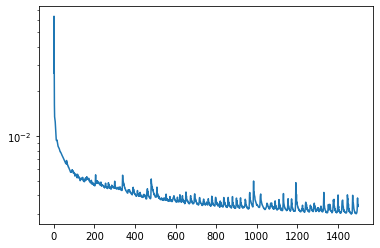

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
1 24.620010990768115rain loss 0.011637  Actual loss 0.004249 Actual loss orig 0.004249 


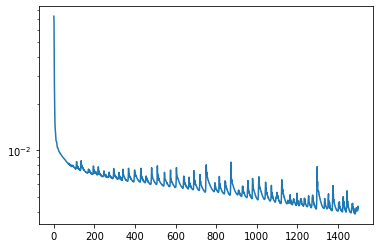

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
2 24.522322952318614rain loss 0.011380  Actual loss 0.003713 Actual loss orig 0.003713 


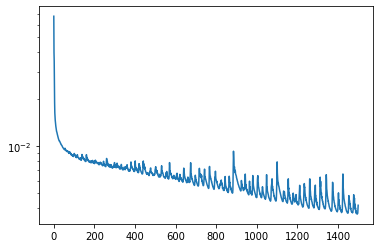

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
3 26.454434342069526rain loss 0.008082  Actual loss 0.000555 Actual loss orig 0.000555 


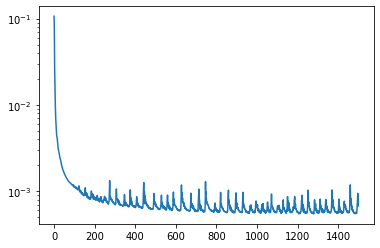

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
4 26.405067809407235rain loss 0.009628  Actual loss 0.002527 Actual loss orig 0.002527 


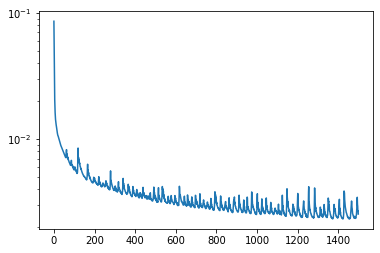

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
5 26.433938621193175rain loss 0.010267  Actual loss 0.002336 Actual loss orig 0.002336 


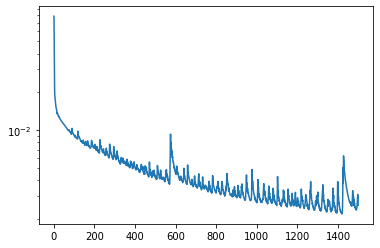

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
6 26.39614013371043Train loss 0.009758  Actual loss 0.002463 Actual loss orig 0.002463 


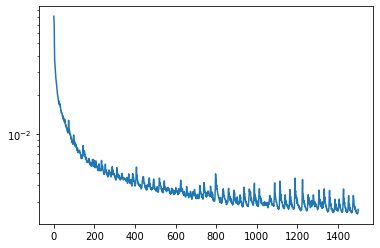

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
7 26.886217883678306rain loss 0.008832  Actual loss 0.000947 Actual loss orig 0.000947 


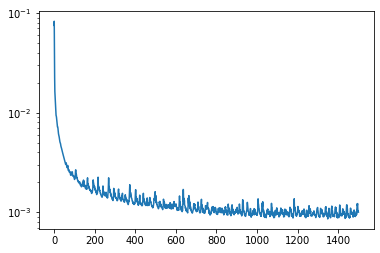

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
8 26.98814797169055Train loss 0.009487  Actual loss 0.001747 Actual loss orig 0.001747 


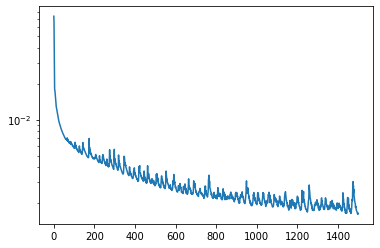

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
9 27.187043188810208rain loss 0.009577  Actual loss 0.001658 Actual loss orig 0.001658 


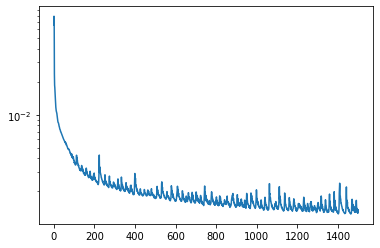

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
10 27.75865178789518rain loss 0.008761  Actual loss 0.000505 Actual loss orig 0.000505 


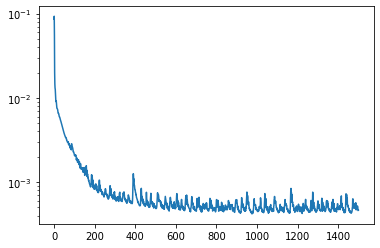

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
11 27.8310718501522Train loss 0.009173  Actual loss 0.001469 Actual loss orig 0.001469 


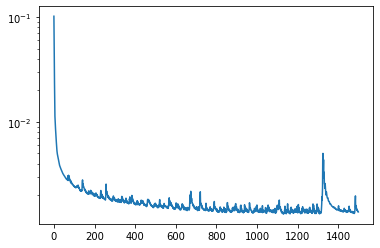

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
12 28.00250437159479rain loss 0.008252  Actual loss 0.001052 Actual loss orig 0.001052 


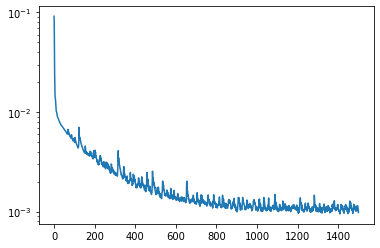

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
13 27.89246325427055rain loss 0.007720  Actual loss 0.002221 Actual loss orig 0.002221 


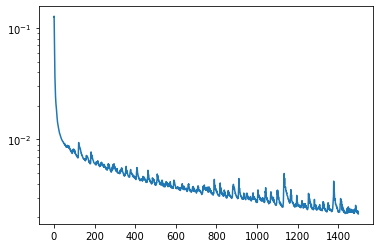

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
14 28.008045620545165ain loss 0.008695  Actual loss 0.001189 Actual loss orig 0.001189 


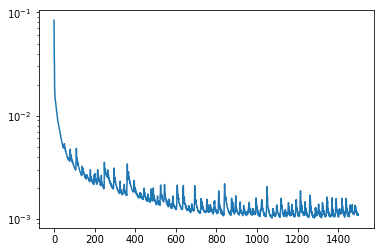

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
15 28.094703845692067ain loss 0.009119  Actual loss 0.001165 Actual loss orig 0.001165 


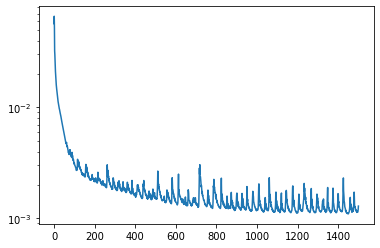

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
16 28.253908356697597ain loss 0.009314  Actual loss 0.000859 Actual loss orig 0.000859 


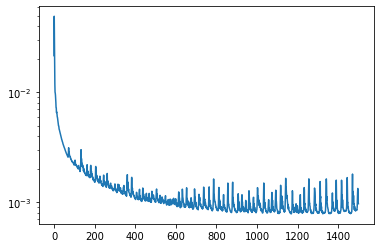

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
17 28.49924102952435rain loss 0.009120  Actual loss 0.000541 Actual loss orig 0.000541 


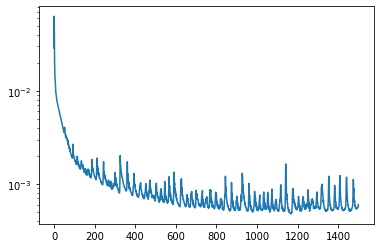

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
18 28.530869553793064ain loss 0.009025  Actual loss 0.001671 Actual loss orig 0.001671 


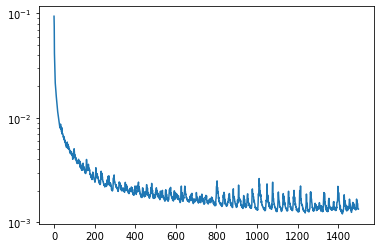

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
19 28.26369653634369rain loss 0.012534  Actual loss 0.004931 Actual loss orig 0.004931 


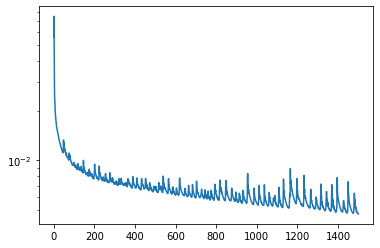

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
20 28.33948926937384rain loss 0.007378  Actual loss 0.000962 Actual loss orig 0.000962 


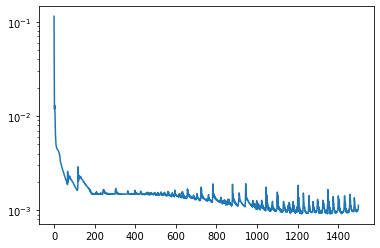

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
21 28.38101098667087rain loss 0.009537  Actual loss 0.001312 Actual loss orig 0.001312 


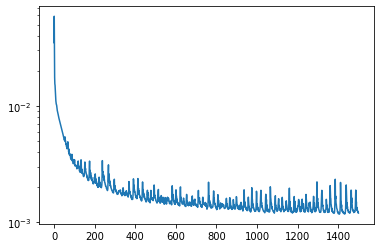

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
22 28.25146298163943rain loss 0.011672  Actual loss 0.003091 Actual loss orig 0.003091 


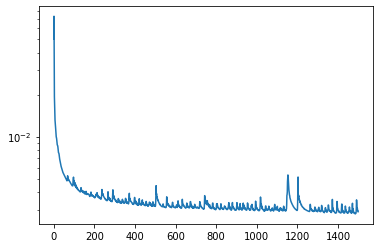

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
23 28.070450743496565ain loss 0.012197  Actual loss 0.004694 Actual loss orig 0.004694 


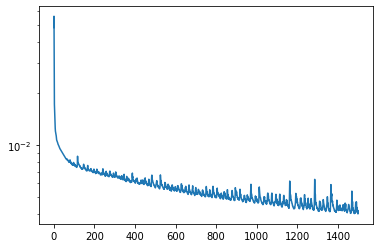

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
24 28.03454270520646rain loss 0.008875  Actual loss 0.002259 Actual loss orig 0.002259 


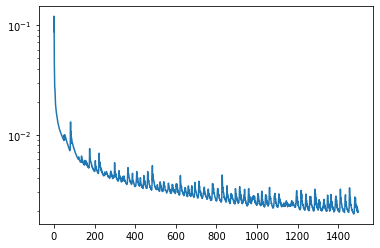

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
25 28.082031524441998ain loss 0.009779  Actual loss 0.001229 Actual loss orig 0.001229 


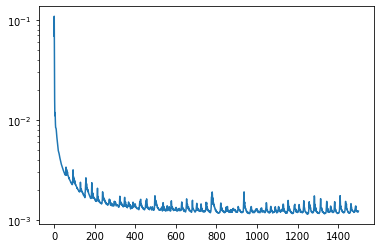

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
26 28.082844366237705ain loss 0.008252  Actual loss 0.001573 Actual loss orig 0.001573 


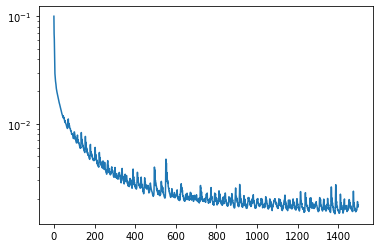

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
27 28.1686050970805Train loss 0.009416  Actual loss 0.001214 Actual loss orig 0.001214 


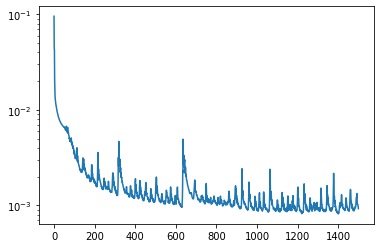

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
28 28.017695454694863ain loss 0.011733  Actual loss 0.004134 Actual loss orig 0.004134 


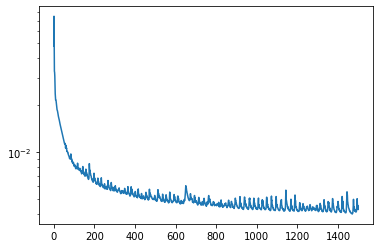

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
29 28.05141621885945rain loss 0.009796  Actual loss 0.001392 Actual loss orig 0.001392 


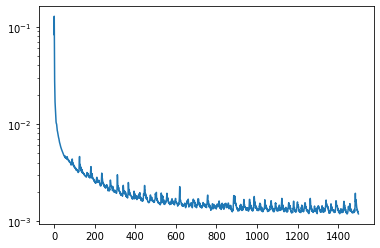

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
30 27.94236782944078rain loss 0.011617  Actual loss 0.003714 Actual loss orig 0.003714 


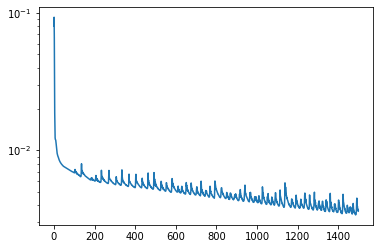

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
31 28.006475768923785ain loss 0.006854  Actual loss 0.000982 Actual loss orig 0.000982 


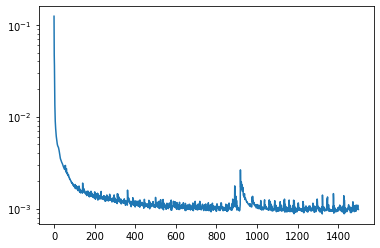

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
32 28.078129074171102ain loss 0.007294  Actual loss 0.000939 Actual loss orig 0.000939 


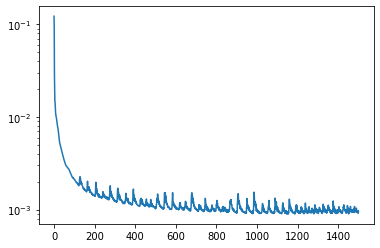

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
33 28.05455570048157rain loss 0.010520  Actual loss 0.001941 Actual loss orig 0.001941 


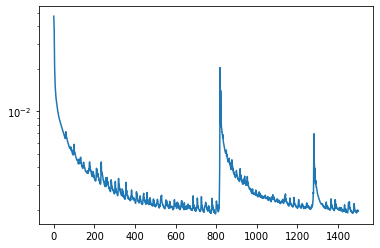

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
34 28.171064942921113ain loss 0.009171  Actual loss 0.000654 Actual loss orig 0.000654 


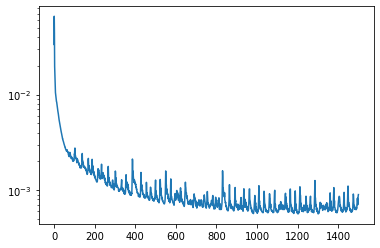

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
35 28.136747826329504ain loss 0.007882  Actual loss 0.002534 Actual loss orig 0.002534 


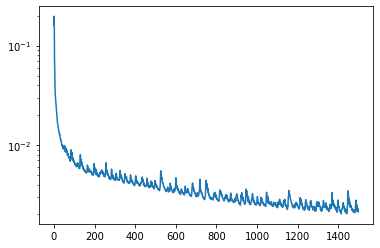

input shape:  [1, 512, 16, 16]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



55 28.448556820446328ain loss 0.009473  Actual loss 0.000524 Actual loss orig 0.000524 


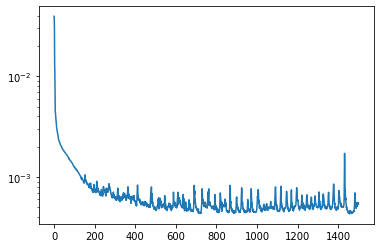

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
56 28.409261666979425ain loss 0.004908  Actual loss 0.002474 Actual loss orig 0.002474 


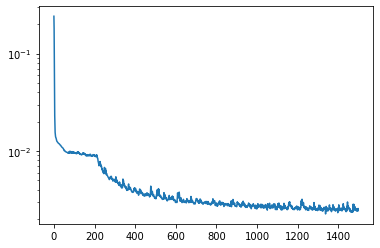

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
57 28.426889385051833ain loss 0.008695  Actual loss 0.001144 Actual loss orig 0.001144 


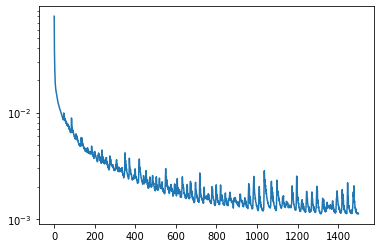

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
58 28.438210024293635ain loss 0.008669  Actual loss 0.001428 Actual loss orig 0.001428 


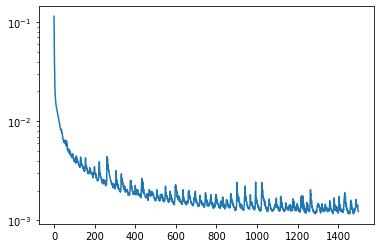

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
59 28.386790464245212ain loss 0.010035  Actual loss 0.003047 Actual loss orig 0.003047 


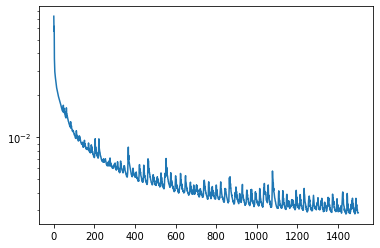

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
60 28.33888639856602rain loss 0.010776  Actual loss 0.002854 Actual loss orig 0.002854 


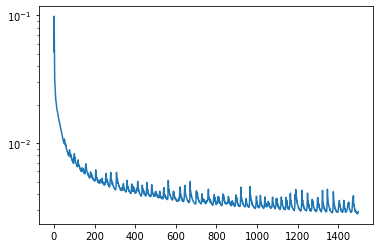

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
61 28.16434937546605rain loss 0.025857  Actual loss 0.017663 Actual loss orig 0.017663 


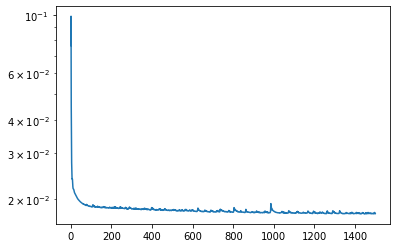

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
62 28.172327338610224ain loss 0.008864  Actual loss 0.001342 Actual loss orig 0.001342 


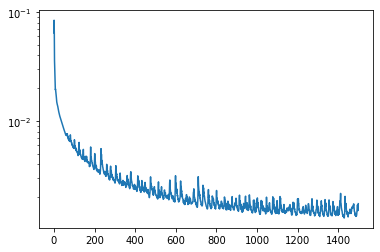

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
63 28.22596281858589rain loss 0.008818  Actual loss 0.000923 Actual loss orig 0.000923 


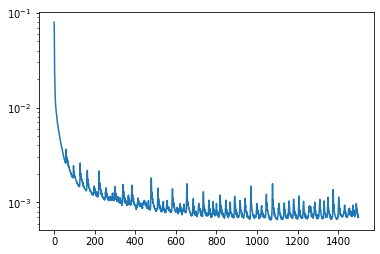

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
64 28.166754042087838ain loss 0.010965  Actual loss 0.003650 Actual loss orig 0.003650 


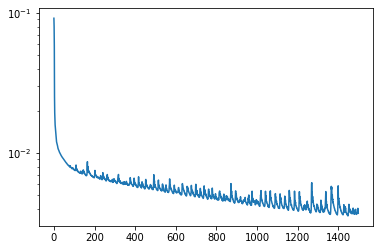

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
65 28.095154964970018ain loss 0.011500  Actual loss 0.004484 Actual loss orig 0.004484 


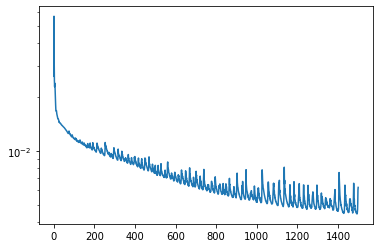

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
66 28.118165972805194ain loss 0.009244  Actual loss 0.001201 Actual loss orig 0.001201 


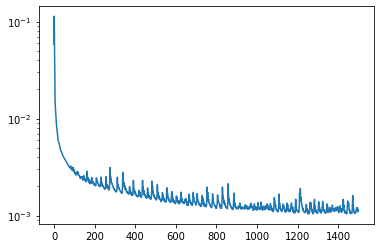

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
67 28.155239342937005ain loss 0.009280  Actual loss 0.000991 Actual loss orig 0.000991 


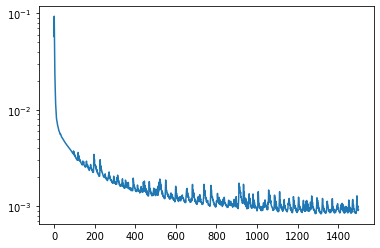

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
68 28.170169903479202ain loss 0.009441  Actual loss 0.001171 Actual loss orig 0.001171 


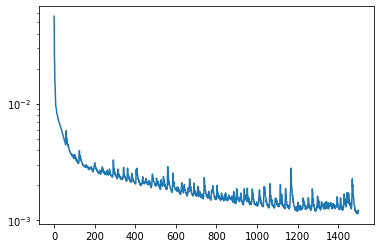

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
69 28.152194373099537ain loss 0.007260  Actual loss 0.002554 Actual loss orig 0.002554 


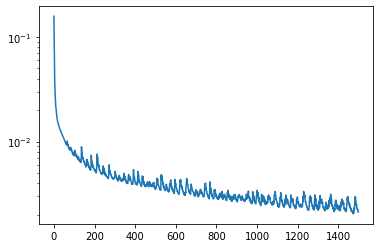

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
70 28.098827223700535ain loss 0.010004  Actual loss 0.003413 Actual loss orig 0.003413 


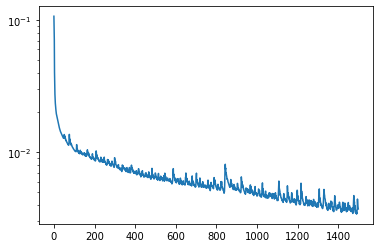

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
71 28.054631135171576ain loss 0.011056  Actual loss 0.003253 Actual loss orig 0.003253 


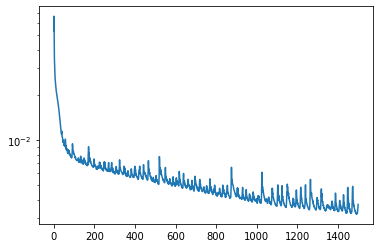

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
72 28.11350261707511rain loss 0.009080  Actual loss 0.000589 Actual loss orig 0.000589 


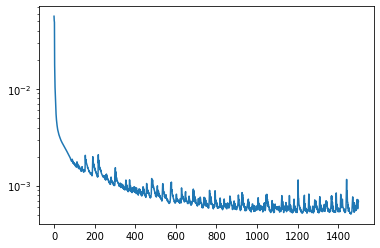

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
73 28.159825487146456ain loss 0.009435  Actual loss 0.000767 Actual loss orig 0.000767 


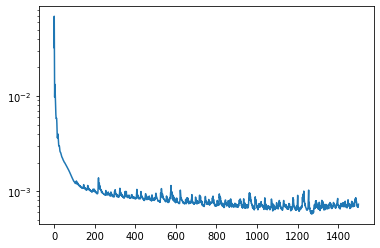

input shape:  [1, 512, 16, 16]
optimize with adam 0.01
74 28.137845947439363ain loss 0.009698  Actual loss 0.002434 Actual loss orig 0.002434 


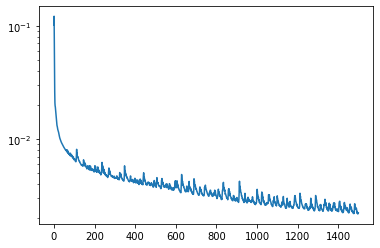

input shape:  [1, 512, 16, 16]
optimize with adam 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
psnrs = [] 
for i,img in enumerate(imgs):
    # get noisy img
    img_noisy_np = get_noisy_img(img,sig,noise_same)
    output_depth = img.shape[0] 
    # denoise with DD
    num_channels = [512]*5
    net = decodernw(output_depth,num_channels_up=num_channels,bn_before_act = True).type(dtype)
    out_img_np, mse_t = denoise(img_noisy_np,img,net,num_channels=num_channels,numit = 1500)
    psnrv = psnr(img,out_img_np)
    psnrs.append(psnrv)
    print(i, np.mean(psnrs))
    
    #plt.semilogy(mse_t)
    #plt.show()
    
print(np.mean(psnrs))

In [9]:
print(np.mean(psnrs))

28.085956176050704
